# Statistics in `cytoflow`

One of the most powerful concepts in `cytoflow` is that it makes it easy to summarize your data, then track how those subsets change as your experimental variables change.  This notebook demonstrates several different modules that create and plot statistics.

---

Set up the Jupyter `matplotlib` integration, and import the `cytoflow` module.

In [1]:
# in some buggy versions of the Jupyter notebook, this needs to be in its OWN CELL.
%matplotlib inline

In [2]:
import cytoflow as flow

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
matplotlib.rc('figure', dpi = 160)

We use the same data set as the **Yeast Dose Response** example notebook, with one variant: we load each tube three times, grabbing only 100 events from each.

In [3]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.items():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 1}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 2}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 3}))

    
ex = flow.ImportOp(conditions = {'IP' : "float", "Replicate" : "int"},
                   tubes = tubes,
                   events = 100).apply()

In `cytoflow`, a *statistic* is a value that summarizes something about some data.  `cytoflow` makes it easy to compute statistics for various subsets.  For example, if we expect the geometric mean of `FITC-A` channel to change as the `IP` variable changes, we can compute the geometric mean of the `FITC-A` channel of each different `IP` condition with the `ChannelStatisticOp` operation:

In [4]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)

This operation splits the data set by different values of `IP`, then applies the function `flow.geom_mean` to the `FITC-A` channel in each subset. The result is stored in the `statistics` attribute of an `Experiment`. The `statistics` attribute is a dictionary.  The keys are tuples, where the first element in the tuple is the name of the operation that created the statistic, and the second element is specific to the operation:

In [5]:
ex2.statistics.keys()

dict_keys([('ByIP', 'geom_mean')])

The `Statistics1DOp` operation sets the second element of the tuple to the function name.  (You can override this by setting `Statistics1DOp.statistic_name`; this is useful if `function` is a lambda function.)

The value of each entry in `Experiment.statistics` is a `pandas.Series`.  The series index is all the subsets for which the statistic was computed, and the contents are the values of the statstic itself.

In [6]:
ex2.statistics[('ByIP', 'geom_mean')]

IP    
0.0159     106.760464
0.0211     145.242912
0.0282     152.152489
0.0376     194.243504
0.0500     240.788179
0.0668     413.218589
0.0892     670.798705
0.1188     971.121453
0.1584    1345.581190
0.2112    1203.016726
0.2816    1463.993731
0.3754    1733.702533
0.5000    1871.968527
0.6674    2218.190937
0.8899    2324.630935
1.1865    2486.103908
1.5820    2456.024025
2.1090    2326.584475
2.8125    2350.038991
3.7500    2676.275419
5.0000    2269.741514
Name: ByIP : geom_mean, dtype: float64

We can also specify multiple variables to break data set into.  In the example above, `Statistics1DOp` lumps all events with the same value of `IP` together, but each amount of `IP` actually has three values of `Replicate` as well.  Let's apply `geom_mean` to each unique combination of `IP` and `Replicate`:

In [7]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP", "Replicate"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)
ex2.statistics[("ByIP", "geom_mean")][0:12]

IP      Replicate
0.0159  1            109.294581
        2            106.956580
        3            104.099598
0.0211  1            144.564288
        2            147.712897
        3            143.484638
0.0282  1            155.558697
        2            156.508248
        3            144.679053
0.0376  1            182.294878
        2            206.147145
        3            195.023849
Name: ByIP : geom_mean, dtype: float64

Note that the `pandas.Series` now has a `MultiIndex`: there are values for each unique combination of `IP` and `Replicate`.

---

Now that we have computed a statistic, we can plot it with one of the statistics views.  We can use a bar chart:

In [8]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP").plot(ex2)

CytoflowViewError: ('plot_name', "You must use facets ['Replicate'] in either the plot variables or the plot name. Possible plot names: [1, 2, 3]")

Oops!  We forgot to specify how to plot the different `Replicate`s.  Each index of a statistic must be specified as either a variable or a facet of the plot, like so:

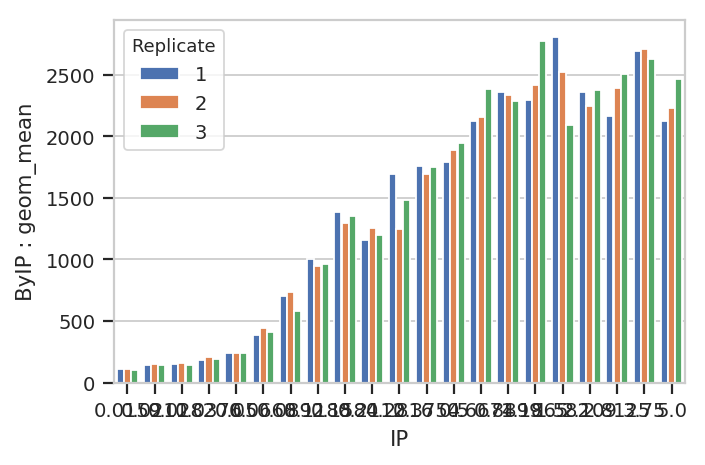

In [9]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2)

A quick aside - sometimes you get ugly axes because of overlapping labels.  In this case, we want a wider plot.  While we can directly specify the height of a plot, we can't directly specify its width, only its aspect ratio (the ratio of the width to the height.)  `cytoflow` defaults to 1.5; in this case, let's widen it out to 4.  If this results in a plot that's wider than your browser, the Jupyter notebook will scale it down for you.

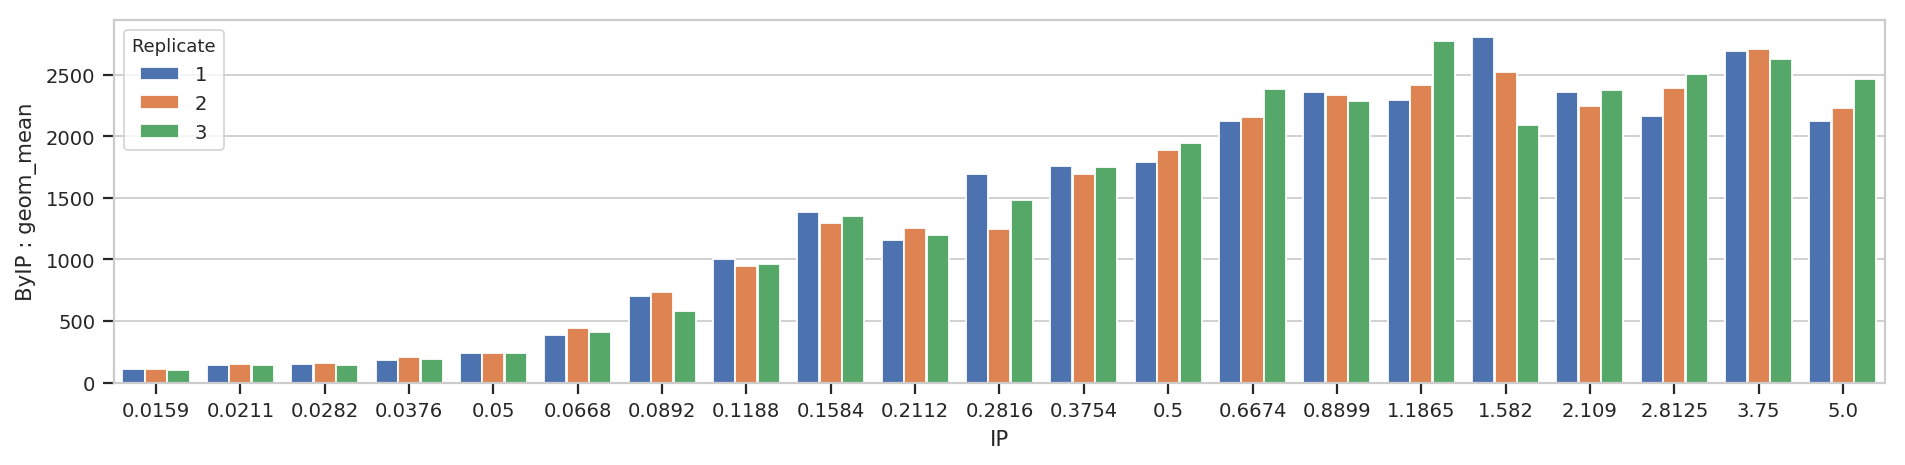

In [10]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2, aspect = 4)

Bar charts are really best for categorical variables (with a modest number of categories.)  Let's do a line chart instead:

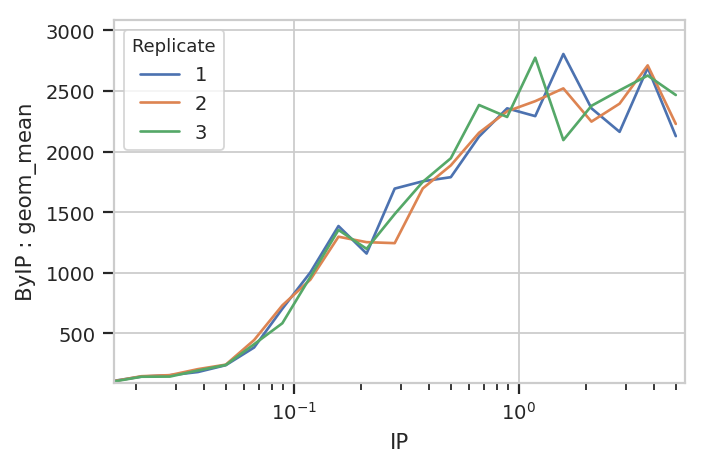

In [11]:
flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 variable = "IP",
                 variable_scale = 'log',
                 huefacet = "Replicate").plot(ex2)

Statistics views can also plot error bars; the error bars must *also* be a statistic, and they must have the same indices as the "main" statistic.  For example, let's plot the geometric mean and geometric standard deviation of each IP subset:

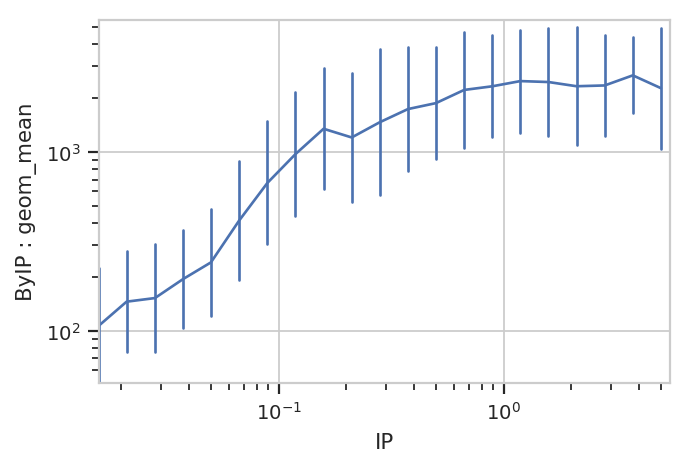

In [12]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = flow.geom_mean).apply(ex)

# While an arithmetic SD is usually plotted plus-or-minus the arithmetic mean, 
# a *geometric* SD is usually plotted (on a log scale!) multiplied-or-divided by the 
# geometric mean.  the function geom_sd_range is a convenience function that does this.

ex3 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ['IP'],
                              channel = "FITC-A",
                              function = flow.geom_sd_range).apply(ex2)

flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 variable = "IP",
                 variable_scale = "log",
                 scale = "log",
                 error_statistic = ("ByIP", "geom_sd_range")).plot(ex3)

The plot above shows how one statistic varies (on the Y axis) as a variable changes on the X axis.  We can also plot two statistics against eachother.  For example, we can ask if the geometric standard deviation varies as the geometric mean changes:

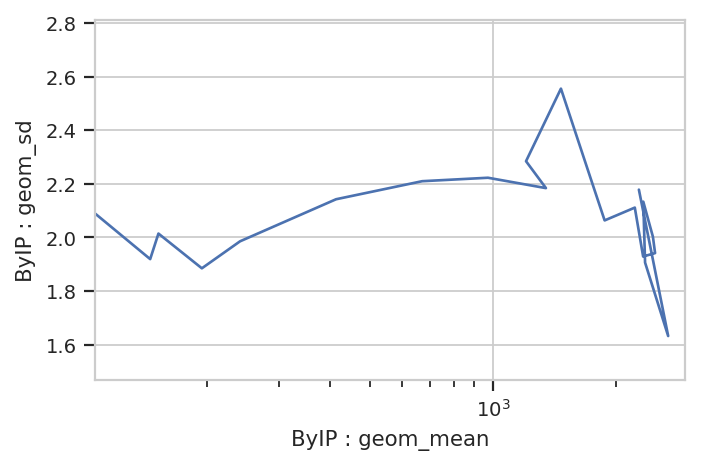

In [13]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = flow.geom_mean).apply(ex)

ex3 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ['IP'],
                              channel = "FITC-A",
                              function = flow.geom_sd).apply(ex2)

flow.Stats2DView(variable = "IP",
                 xstatistic = ("ByIP", "geom_mean"),
                 ystatistic = ("ByIP", "geom_sd"),
                 xscale = "log").plot(ex3)

Nope, guess not.  See the **TASBE Calibrated Flow Cytometry** notebook for more examples of 1D and 2D statistics views.

---

# Transforming statistics

In addition to making statistics by applying summary functions to data, you can also apply functions to other statistics.  For example, a common question is "What percentage of my events are in a particular gate?"  We could, for instance, ask what percentage of events are above 1000 in the `FITC-A` channel, and how that varies by amount of `IP`. We start by defining a *threshold* gate with `ThresholdOp`:

In [14]:
thresh = flow.ThresholdOp(name = "Above1000",
                          channel = "FITC-A",
                          threshold = 1000)
ex2 = thresh.apply(ex)

Now, the `Experiment` has a condition named `Above1000` that is `True` or `False` depending on whether that event's `FITC-A` channel is greater than 1000.  Next, we compute the total number of events in each subset with a unique combination of `Above1000` and `IP`:

In [15]:
ex3 = flow.ChannelStatisticOp(name = "Above1000",
                              by = ["Above1000", "IP"],
                              channel = "FITC-A",
                              function = len).apply(ex2)
ex3.statistics[("Above1000", "len")]

Above1000  IP    
False      0.0159    299
           0.0211    299
           0.0282    299
           0.0376    296
           0.0500    299
           0.0668    262
           0.0892    200
           0.1188    143
           0.1584     76
           0.2112    101
           0.2816     76
           0.3754     57
           0.5000     53
           0.6674     32
           0.8899     19
           1.1865     23
           1.5820     21
           2.1090     34
           2.8125     25
           3.7500     10
           5.0000     29
True       0.0159      1
           0.0211      1
           0.0282      1
           0.0376      4
           0.0500      1
           0.0668     38
           0.0892    100
           0.1188    157
           0.1584    224
           0.2112    199
           0.2816    224
           0.3754    243
           0.5000    247
           0.6674    268
           0.8899    281
           1.1865    277
           1.5820    279
           2.1090    266
       

And now we compute the proportion of `Above1000 == True` for each value of `IP`.  `TransformStatisticOp` applies a function to subsets of a statistic; in this case, we're applying a `lambda` function to convert each `IP` subset from length into proportion.

In [16]:
import pandas as pd

ex4 = flow.TransformStatisticOp(name = "Above1000",
                                statistic = ("Above1000", "len"),
                                by = ["IP"],
                                function = lambda a: pd.Series(a / a.sum()),
                                statistic_name = "proportion").apply(ex3)

ex4.statistics[("Above1000", "proportion")][0:8]

Above1000  IP    
False      0.0159    0.996667
           0.0211    0.996667
           0.0282    0.996667
           0.0376    0.986667
           0.0500    0.996667
           0.0668    0.873333
           0.0892    0.666667
           0.1188    0.476667
Name: Above1000 : len, dtype: float64

Now we can plot the new statistic.

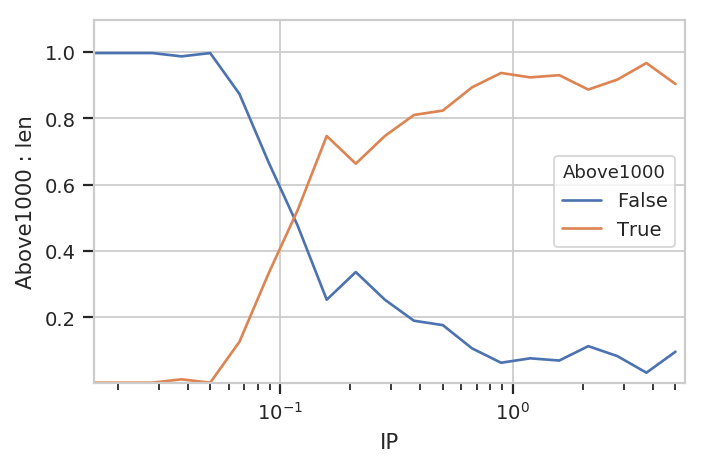

In [17]:
flow.Stats1DView(statistic = ("Above1000", "proportion"),
                 variable = "IP",
                 variable_scale = "log",
                 huefacet = "Above1000").plot(ex4)

Note that be default we get all the values in the statistic; in this case, it's both the proportion that's above 1000 (`True`) and the proportion that is below it (`False`).  We can pass a `subset` attribute to the `Stats1DView` to look at just one or the other. 

/home/brian/src/cytoflow/cytoflow/views/base_views.py:751: CytoflowViewWarning: Only one value for level Above1000; dropping it.


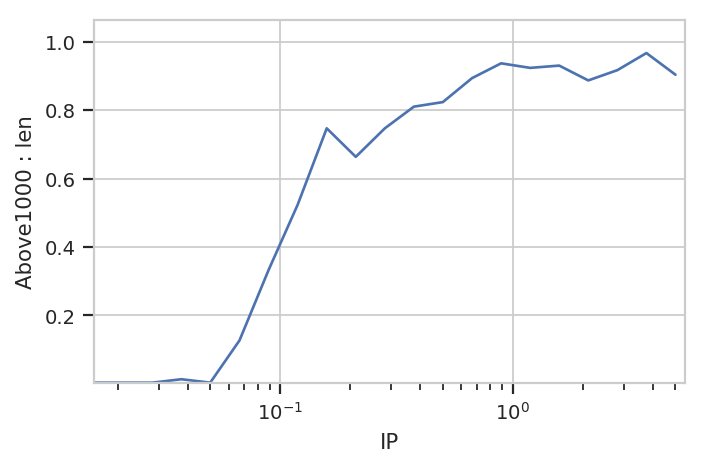

In [18]:
flow.Stats1DView(statistic = ("Above1000", "proportion"),
                 variable = "IP",
                 variable_scale = "log",
                 subset = "Above1000 == True").plot(ex4)

Note the warning.  Because the index level `Above1000` is always `True` in this subset, it gets dropped from the index.  Note also that we don't have to specify it as a variable or facet anywhere.

---

# Statistics from data-driven modules

One of the most exciting aspects of statistics in `cytoflow` is that other data-driven modules can add them to an `Experiment`, too.  For example, the `GaussianMixtureOp` adds several statistics for each component of the mixture model it fits, containing the mean, standard deviation and proportion of observations in each component:

In [19]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.items():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip}))

    
ex = flow.ImportOp(conditions = {'IP' : "float"},
                   tubes = tubes).apply()

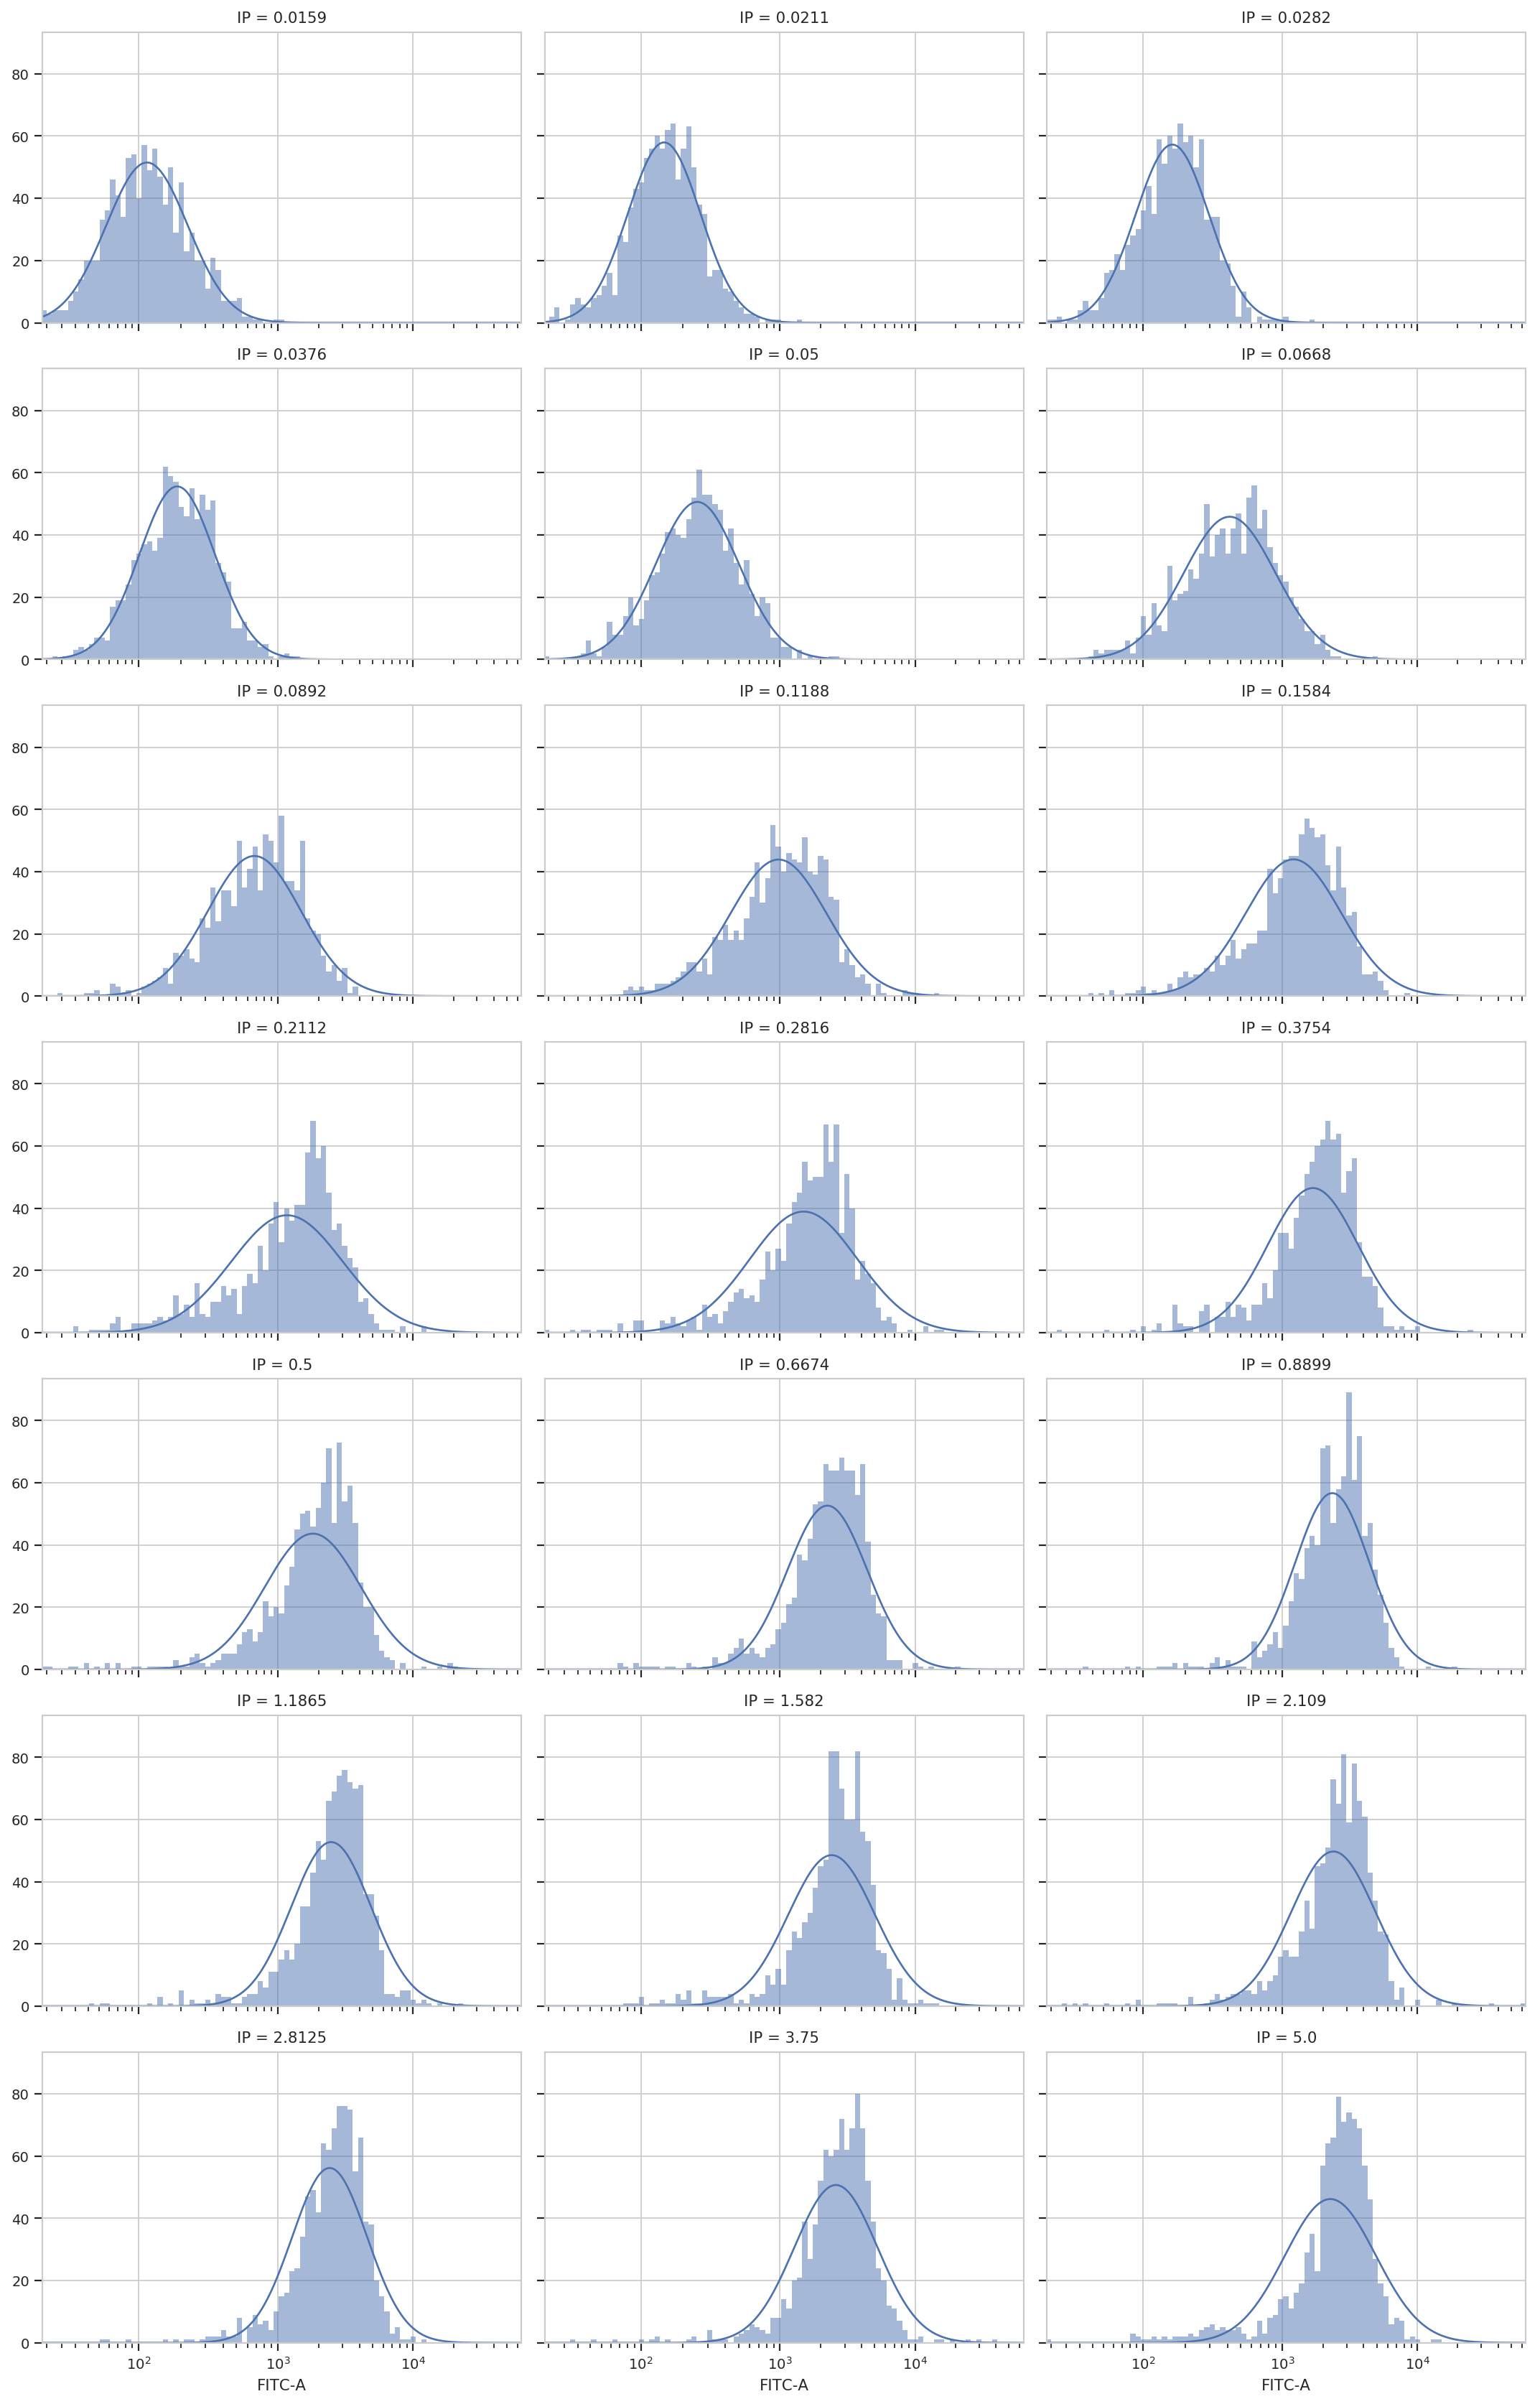

In [20]:
op = flow.GaussianMixtureOp(name = "Gauss",
                            channels = ["FITC-A"],
                            scale = {"FITC-A" : 'logicle'},
                            by = ["IP"],
                            num_components = 1)
op.estimate(ex)
ex2 = op.apply(ex)
op.default_view(xfacet = "IP").plot(ex2, col_wrap = 3)

In [21]:
ex2.statistics.keys()

dict_keys([('Gauss', 'mean'), ('Gauss', 'sigma'), ('Gauss', 'interval')])

In [22]:
ex2.statistics[("Gauss", 'mean')]

IP      Component  Channel
0.0159  1          FITC-A      114.867593
0.0211  1          FITC-A      146.760865
0.0282  1          FITC-A      161.831942
0.0376  1          FITC-A      188.241811
0.0500  1          FITC-A      252.533895
0.0668  1          FITC-A      415.359435
0.0892  1          FITC-A      675.335896
0.1188  1          FITC-A      976.574632
0.1584  1          FITC-A     1212.127491
0.2112  1          FITC-A     1169.357113
0.2816  1          FITC-A     1491.938821
0.3754  1          FITC-A     1683.611714
0.5000  1          FITC-A     1812.128528
0.6674  1          FITC-A     2233.860489
0.8899  1          FITC-A     2341.076532
1.1865  1          FITC-A     2474.300525
1.5820  1          FITC-A     2401.710245
2.1090  1          FITC-A     2383.285932
2.8125  1          FITC-A     2411.122019
3.7500  1          FITC-A     2584.007182
5.0000  1          FITC-A     2265.732416
Name: Gauss : mean, dtype: float64

In [23]:
ex2.statistics[("Gauss", 'interval')]

IP      Component  Channel
0.0159  1          FITC-A       (56.94459866110697, 224.1783518669721)
0.0211  1          FITC-A       (80.36534657785384, 265.7842407147643)
0.0282  1          FITC-A       (88.27508462690886, 295.4218184072569)
0.0376  1          FITC-A      (101.18497543667104, 350.4182139054138)
0.0500  1          FITC-A     (127.95204222704295, 502.06564927968213)
0.0668  1          FITC-A       (195.2351392293184, 894.5712089072493)
0.0892  1          FITC-A     (310.61832832262314, 1484.6617729462246)
0.1188  1          FITC-A       (437.6150673574889, 2200.017570462604)
0.1584  1          FITC-A      (542.1024597233911, 2732.4410991530126)
0.2112  1          FITC-A      (459.2685949581729, 3011.3302773605374)
0.2816  1          FITC-A      (601.1140138003304, 3736.1069195737864)
0.3754  1          FITC-A      (784.0312198090705, 3635.8937650247603)
0.5000  1          FITC-A       (802.3248292365361, 4117.843046843494)
0.6674  1          FITC-A      (1134.2954460750368

/home/brian/src/cytoflow/cytoflow/views/base_views.py:751: CytoflowViewWarning: Only one value for level Component; dropping it.
/home/brian/src/cytoflow/cytoflow/views/base_views.py:751: CytoflowViewWarning: Only one value for level Channel; dropping it.


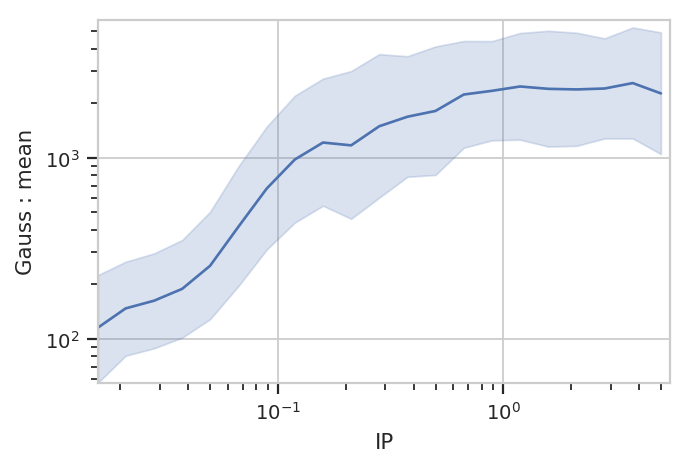

In [24]:
flow.Stats1DView(statistic = ("Gauss", "mean"),
                 variable = "IP",
                 variable_scale = "log",
                 scale = "log",
                 error_statistic = ("Gauss", "interval")).plot(ex2, shade_error = True)